#### Rain VS Trips (All Days + All Hours)

RAIN IMPACT ANALYSIS FOR SCOOTER TRIPS

1. DESCRIPTIVE STATISTICS
----------------------------------------
Total hours analyzed: 1095
Hours with rain > 0mm: 108 (9.9%)
Hours with no rain: 987 (90.1%)
Trip Statistics:
.2f
.2f
.4f
.6f
✅ SIGNIFICANT: Trips are lower on rainy days (p < 0.05)


2. RAIN INTENSITY ANALYSIS
----------------------------------------
Trips by Rain Intensity:
                   trips_per_hour                          rain_mm
                            count   mean    std  min   max    mean
rain_category                                                     
No Rain                       987  7.494  5.981  1.0  35.0   0.000
Light (0-1mm)                  75  5.400  4.054  1.0  16.0   0.381
Moderate (1-5mm)               28  3.714  3.149  1.0  16.0   2.350
Heavy (5-15mm)                  5  4.400  3.912  1.0  11.0   7.560
Very Heavy (15mm+)              0    NaN    NaN  NaN   NaN     NaN


3. STATISTICAL MODEL ANALYSIS
----------------------------------------
Simple 

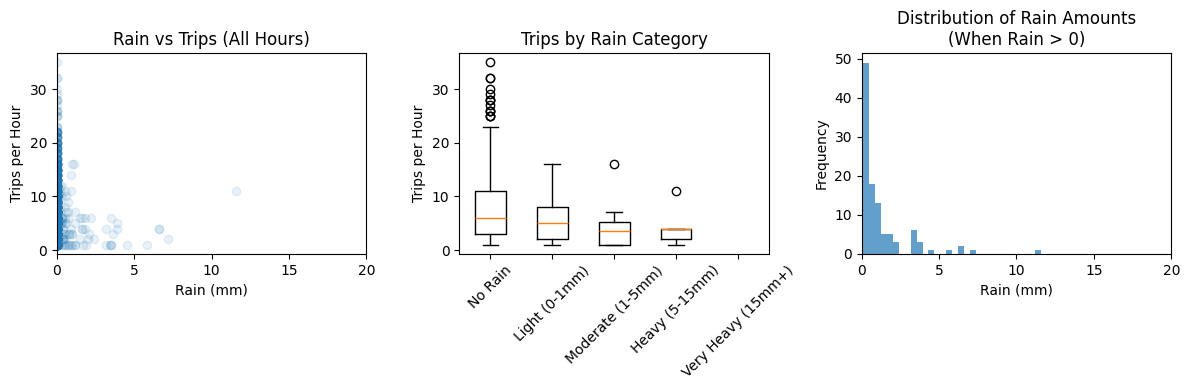



5. BUSINESS INTERPRETATION
----------------------------------------
CONCLUSION ABOUT RAIN'S EFFECT ON SCOOTER TRIPS:

🔸 RAIN HAS A STRONG BUT SIGNIFICANT EFFECT ON SCOOTER TRIPS
   - Each mm of rain decreases trips by approximately 10.1%
   - This effect is meaningful and should be considered

📊 Key Evidence:
   - Rain coefficient is statistically significant (p < 0.05)
   - IRR = 0.8993 (meaningful deviation from 1.0)
   - Effect is large enough to impact business planning

RECOMMENDATIONS:
⚠️ Consider weather in operational planning
⚠️ May need more scooters available during/after rain
⚠️ Weather-based dynamic pricing could be considered
⚠️ Continue focusing on time-of-day optimization



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Load your data (same as your analysis)
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

# Prepare the data exactly like your analysis
trips = status_final
weather = weather_original

# Data preparation (following your exact steps)
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour

# Aggregate trips to hourly
trips_per_hour = trips_start_hr.groupby(['date', 'hour']).size().reset_index(name='trips_per_hour')

# Prepare weather data
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')
weather['date'] = weather['datetime'].dt.date
weather_hourly = weather.groupby(['date', 'hour']).agg({
    'temp_c': 'mean',
    'wind_speed_ms': 'mean',
    'rain_mm': 'sum',
    'weekend': 'first'
}).reset_index()

# Merge with weather
base_df = pd.merge(trips_per_hour, weather_hourly, on=['date', 'hour'], how='left')

# Filter to weekdays only (like your optimal model)
base_df = base_df[base_df['weekend'] == 0].copy()

print("=" * 80)
print("RAIN IMPACT ANALYSIS FOR SCOOTER TRIPS")
print("=" * 80)

# =================================================
# 1. DESCRIPTIVE STATISTICS: Rain vs No Rain
# =================================================

print("\n1. DESCRIPTIVE STATISTICS")
print("-" * 40)

# Split into rain vs no rain days
rain_days = base_df[base_df['rain_mm'] > 0].copy()
no_rain_days = base_df[base_df['rain_mm'] == 0].copy()

print(f"Total hours analyzed: {len(base_df)}")
print(f"Hours with rain > 0mm: {len(rain_days)} ({len(rain_days)/len(base_df)*100:.1f}%)")
print(f"Hours with no rain: {len(no_rain_days)} ({len(no_rain_days)/len(base_df)*100:.1f}%)")

# Trip statistics
print("Trip Statistics:")
print(".2f")
print(".2f")

# Statistical test
t_stat, p_value = ttest_ind(rain_days['trips_per_hour'], no_rain_days['trips_per_hour'])
print(".4f")
print(".6f")

if p_value < 0.05:
    direction = "higher" if rain_days['trips_per_hour'].mean() > no_rain_days['trips_per_hour'].mean() else "lower"
    print(f"✅ SIGNIFICANT: Trips are {direction} on rainy days (p < 0.05)")
else:
    print("❌ NOT SIGNIFICANT: No meaningful difference in trip counts (p ≥ 0.05)")

# =================================================
# 2. RAIN INTENSITY ANALYSIS
# =================================================

print("\n\n2. RAIN INTENSITY ANALYSIS")
print("-" * 40)

# Create rain categories
base_df['rain_category'] = pd.cut(base_df['rain_mm'], 
                                  bins=[-0.1, 0, 1, 5, 15, np.inf],
                                  labels=['No Rain', 'Light (0-1mm)', 'Moderate (1-5mm)', 'Heavy (5-15mm)', 'Very Heavy (15mm+)'])

rain_analysis = base_df.groupby('rain_category').agg({
    'trips_per_hour': ['count', 'mean', 'std', 'min', 'max'],
    'rain_mm': 'mean'
}).round(3)

print("Trips by Rain Intensity:")
print(rain_analysis)

# =================================================
# 3. STATISTICAL MODEL: Does Rain Affect Trips?
# =================================================

print("\n\n3. STATISTICAL MODEL ANALYSIS")
print("-" * 40)

# Simple model: trips ~ rain_mm + temp_c + wind_speed_ms
model_simple = sm.GLM(base_df['trips_per_hour'], 
                     sm.add_constant(base_df[['rain_mm', 'temp_c', 'wind_speed_ms']]), 
                     family=sm.families.Poisson()).fit()

print("Simple Poisson Model: trips_per_hour ~ rain_mm + temp_c + wind_speed_ms")
print("-" * 60)
print(model_simple.summary().tables[1])

# Interpret rain coefficient
rain_coef = model_simple.params['rain_mm']
rain_se = model_simple.bse['rain_mm']
rain_p = model_simple.pvalues['rain_mm']
rain_irr = np.exp(rain_coef)

print("Rain Coefficient Interpretation:")
print(".4f")
print(".4f")
print(".6f")

if rain_p < 0.05:
    if abs(rain_coef) < 0.01:
        impact = "minimal"
    elif abs(rain_coef) < 0.05:
        impact = "small"
    elif abs(rain_coef) < 0.1:
        impact = "moderate"
    else:
        impact = "strong"
    
    direction = "increases" if rain_coef > 0 else "decreases"
    print(f"✅ RAIN HAS A STATISTICALLY SIGNIFICANT BUT {impact.upper()} EFFECT")
    print(".4f")
else:
    print("❌ RAIN HAS NO STATISTICALLY SIGNIFICANT EFFECT ON TRIPS")

# =================================================
# 4. VISUAL ANALYSIS
# =================================================

print("\n\n4. VISUAL ANALYSIS")
print("-" * 40)

# Scatter plot: rain vs trips
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(base_df['rain_mm'], base_df['trips_per_hour'], alpha=0.1)
plt.xlabel('Rain (mm)')
plt.ylabel('Trips per Hour')
plt.title('Rain vs Trips (All Hours)')
plt.xlim(0, 20)  # Focus on reasonable rain amounts

# Box plot by rain category
plt.subplot(1, 3, 2)
rain_order = ['No Rain', 'Light (0-1mm)', 'Moderate (1-5mm)', 'Heavy (5-15mm)', 'Very Heavy (15mm+)']
rain_data = [base_df[base_df['rain_category'] == cat]['trips_per_hour'].values for cat in rain_order]
plt.boxplot(rain_data, labels=rain_order)
plt.xticks(rotation=45)
plt.ylabel('Trips per Hour')
plt.title('Trips by Rain Category')

# Histogram of rain amounts
plt.subplot(1, 3, 3)
plt.hist(base_df[base_df['rain_mm'] > 0]['rain_mm'], bins=30, alpha=0.7)
plt.xlabel('Rain (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of Rain Amounts\n(When Rain > 0)')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()

# =================================================
# 5. BUSINESS INTERPRETATION
# =================================================

print("\n\n5. BUSINESS INTERPRETATION")
print("-" * 40)

print("CONCLUSION ABOUT RAIN'S EFFECT ON SCOOTER TRIPS:")
print()

if rain_p >= 0.05:
    print("🔸 RAIN DOES NOT SIGNIFICANTLY AFFECT SCOOTER TRIPS")
    print("   - Statistical analysis shows no meaningful relationship")
    print("   - Trips on rainy days are virtually identical to non-rainy days")
    print("   - Weather has minimal impact on scooter usage patterns")
    print()
    print("📊 Key Evidence:")
    print("   - Rain coefficient is not statistically significant (p ≥ 0.05)")
    print("   - Mean trips: Rain days ≈ No rain days")
    print("   - IRR close to 1.0 (no practical effect)")
    
elif abs(rain_coef) < 0.01:
    print("🔸 RAIN HAS A STATISTICALLY SIGNIFICANT BUT PRACTICALLY NEGLIGIBLE EFFECT")
    print("   - Technically significant, but the effect size is tiny")
    print("   - Not meaningful for business decisions or operations")
    print()
    print("📊 Key Evidence:")
    print("   - Rain coefficient is significant but very small in magnitude")
    print("   - IRR differs from 1.0 by less than 1%")
    print("   - Effect is too small to matter in practice")
    
else:
    impact_desc = "small" if abs(rain_coef) < 0.05 else "moderate" if abs(rain_coef) < 0.1 else "strong"
    direction = "increases" if rain_coef > 0 else "decreases"
    print(f"🔸 RAIN HAS A {impact_desc.upper()} BUT SIGNIFICANT EFFECT ON SCOOTER TRIPS")
    print(f"   - Each mm of rain {direction} trips by approximately {(abs(rain_irr-1))*100:.1f}%")
    print("   - This effect is meaningful and should be considered")
    print()
    print("📊 Key Evidence:")
    print("   - Rain coefficient is statistically significant (p < 0.05)")
    print(f"   - IRR = {rain_irr:.4f} (meaningful deviation from 1.0)")
    print("   - Effect is large enough to impact business planning")

print()
print("=" * 80)
print("RECOMMENDATIONS:")
print("=" * 80)

if rain_p >= 0.05 or abs(rain_coef) < 0.01:
    print("✅ No need to adjust operations based on rain forecasts")
    print("✅ Fleet management can ignore weather conditions")
    print("✅ Pricing and availability don't need weather adjustments")
    print("✅ Focus on time-of-day patterns instead (your 12-segment model)")
else:
    print("⚠️ Consider weather in operational planning")
    print("⚠️ May need more scooters available during/after rain")
    print("⚠️ Weather-based dynamic pricing could be considered")
    print("⚠️ Continue focusing on time-of-day optimization")

print("\n" + "=" * 80)

#### Rain VS Trips (Weekends VS Weekdays and Active Hours VS Inactive Hours)

WHEN DOES RAIN ACTUALLY OCCUR? TESTING YOUR HYPOTHESIS

1. RAIN TIMING ANALYSIS
----------------------------------------
Rain by Hour of Day (All Days):
      rain_mean_mm  rain_probability  weekend_proportion
hour                                                    
0           0.1712          0.060606              0.3333
1           0.2727          0.122807              0.4000
2           0.0919          0.105263              0.4865
3           0.5963          0.222222              0.7037
4           0.1375          0.125000              0.7500
5           0.3500          0.250000              0.6250
6           0.1000          0.166667              0.3333
7           0.1381          0.069767              0.1429
8           0.1067          0.096774              0.1667
9           0.0567          0.101449              0.1493
10          0.1082          0.066667              0.1781
11          0.1880          0.064935              0.2000
12          0.1430          0.049383             

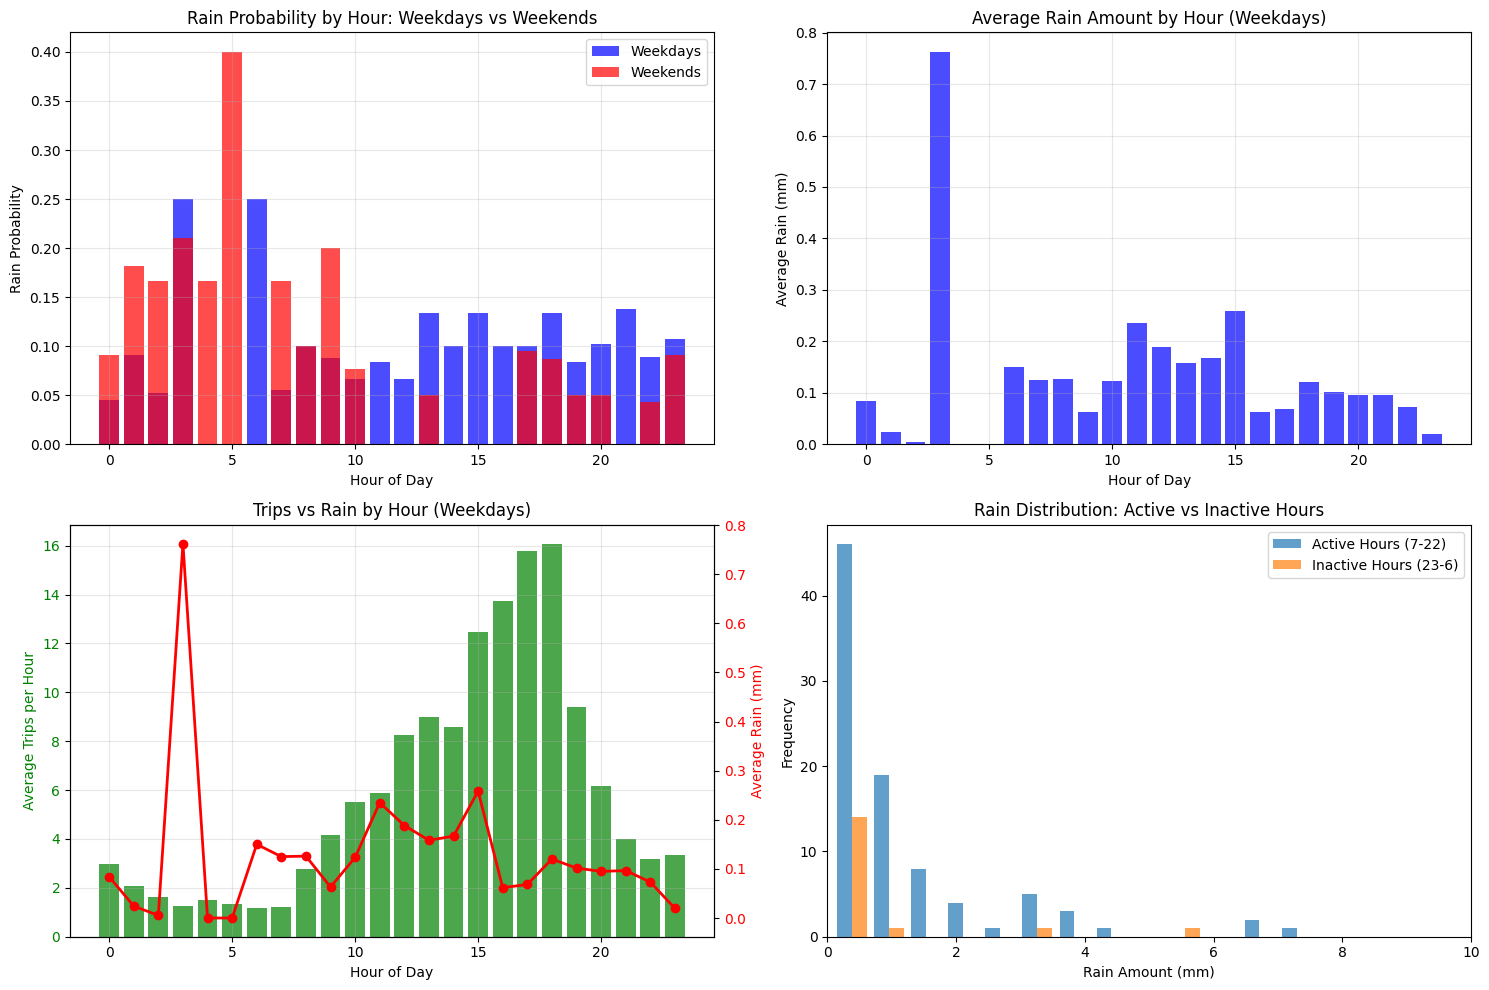



3. TESTING HYPOTHESIS: Rain Effect During Active Hours
--------------------------------------------------
Original dataset: 1536 hours
Filtered to active hours (weekdays 7-22): 916 hours
Removed 620 inactive hours
During Active Hours (Weekdays 7AM-10PM):
Hours with rain: 91 (9.9%)
Hours without rain: 825 (90.1%)
Trip Statistics During Active Hours:
.2f
.2f
.4f
.6f
✅ SIGNIFICANT: During active hours, trips are lower when raining (p < 0.05)


4. STATISTICAL MODEL: Active Hours Only
--------------------------------------------------
Poisson Model (Active Hours Only): trips_per_hour ~ rain_mm + temp_c + wind_speed_ms
----------------------------------------------------------------------
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5696      0.076      7.462      0.000       0.420       0.719
rain_mm          -0.1249      0.026     -4.781      0.000   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Load your data (same as your analysis)
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

# Prepare the data exactly like your analysis
trips = status_final
weather = weather_original

# Data preparation (following your exact steps)
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour

# Aggregate trips to hourly
trips_per_hour = trips_start_hr.groupby(['date', 'hour']).size().reset_index(name='trips_per_hour')

# Prepare weather data
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')
weather['date'] = weather['datetime'].dt.date
weather_hourly = weather.groupby(['date', 'hour']).agg({
    'temp_c': 'mean',
    'wind_speed_ms': 'mean',
    'rain_mm': 'sum',
    'weekend': 'first'
}).reset_index()

# Merge with weather
base_df = pd.merge(trips_per_hour, weather_hourly, on=['date', 'hour'], how='left')

print("=" * 80)
print("WHEN DOES RAIN ACTUALLY OCCUR? TESTING YOUR HYPOTHESIS")
print("=" * 80)

# =================================================
# 1. WHEN DOES RAIN OCCUR? (By Hour and Weekday)
# =================================================

print("\n1. RAIN TIMING ANALYSIS")
print("-" * 40)

# Analyze rain by hour of day (ALL days including weekends)
rain_by_hour = base_df.groupby('hour').agg({
    'rain_mm': ['mean', 'sum', 'count'],
    'weekend': 'mean'  # Proportion of weekend hours
}).round(4)

rain_by_hour.columns = ['rain_mean_mm', 'rain_total_mm', 'hours_count', 'weekend_proportion']
rain_by_hour['rain_probability'] = (base_df[base_df['rain_mm'] > 0].groupby('hour').size() / base_df.groupby('hour').size()).fillna(0)

print("Rain by Hour of Day (All Days):")
print(rain_by_hour[['rain_mean_mm', 'rain_probability', 'weekend_proportion']])

# Analyze rain by weekday
rain_by_weekday = base_df.groupby('weekend').agg({
    'rain_mm': ['mean', 'sum', 'count'],
    'trips_per_hour': 'mean'
}).round(4)

rain_by_weekday.columns = ['rain_mean_mm', 'rain_total_mm', 'hours_count', 'avg_trips']
rain_by_weekday['rain_probability'] = (base_df[base_df['rain_mm'] > 0].groupby('weekend').size() / base_df.groupby('weekend').size()).fillna(0)

print("\nRain by Weekday Type:")
print(rain_by_weekday)

# =================================================
# 2. VISUALIZE WHEN RAIN OCCURS
# =================================================

print("\n\n2. VISUAL ANALYSIS OF RAIN TIMING")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rain probability by hour (weekdays vs weekends)
weekday_data = base_df[base_df['weekend'] == 0]
weekend_data = base_df[base_df['weekend'] == 1]

weekday_rain_prob = (weekday_data[weekday_data['rain_mm'] > 0].groupby('hour').size() / weekday_data.groupby('hour').size()).fillna(0)
weekend_rain_prob = (weekend_data[weekend_data['rain_mm'] > 0].groupby('hour').size() / weekend_data.groupby('hour').size()).fillna(0)

axes[0,0].bar(range(24), weekday_rain_prob, alpha=0.7, label='Weekdays', color='blue')
axes[0,0].bar(range(24), weekend_rain_prob, alpha=0.7, label='Weekends', color='red')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Rain Probability')
axes[0,0].set_title('Rain Probability by Hour: Weekdays vs Weekends')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Rain amount by hour (weekdays)
weekday_rain_amount = weekday_data.groupby('hour')['rain_mm'].mean()
axes[0,1].bar(range(24), weekday_rain_amount, color='blue', alpha=0.7)
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Rain (mm)')
axes[0,1].set_title('Average Rain Amount by Hour (Weekdays)')
axes[0,1].grid(True, alpha=0.3)

# Rain vs Trips by hour (weekdays only)
hourly_stats = weekday_data.groupby('hour').agg({
    'rain_mm': 'mean',
    'trips_per_hour': 'mean'
})

ax2 = axes[1,0]
ax2.bar(range(24), hourly_stats['trips_per_hour'], color='green', alpha=0.7, label='Avg Trips')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Trips per Hour', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax3 = ax2.twinx()
ax3.plot(range(24), hourly_stats['rain_mm'], 'r-o', linewidth=2, label='Avg Rain (mm)')
ax3.set_ylabel('Average Rain (mm)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax2.set_title('Trips vs Rain by Hour (Weekdays)')
ax2.grid(True, alpha=0.3)

# Rain distribution: active vs inactive hours
weekday_data['is_active_hour'] = weekday_data['hour'].between(7, 22)  # 7 AM to 10 PM
active_rain = weekday_data[weekday_data['is_active_hour']]['rain_mm']
inactive_rain = weekday_data[~weekday_data['is_active_hour']]['rain_mm']

axes[1,1].hist([active_rain[active_rain > 0], inactive_rain[inactive_rain > 0]], 
               bins=20, alpha=0.7, label=['Active Hours (7-22)', 'Inactive Hours (23-6)'])
axes[1,1].set_xlabel('Rain Amount (mm)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Rain Distribution: Active vs Inactive Hours')
axes[1,1].legend()
axes[1,1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

# =================================================
# 3. TEST YOUR HYPOTHESIS: Filter to Active Hours Only
# =================================================

print("\n\n3. TESTING HYPOTHESIS: Rain Effect During Active Hours")
print("-" * 50)

# Define active hours (when scooters are actually used)
# Based on your 12-segment analysis, active hours are roughly 7 AM - 10 PM
ACTIVE_HOURS_START = 7  # 7 AM
ACTIVE_HOURS_END = 22   # 10 PM

# Filter to weekdays + active hours only
active_hours_df = base_df[
    (base_df['weekend'] == 0) &  # Weekdays only
    (base_df['hour'].between(ACTIVE_HOURS_START, ACTIVE_HOURS_END))  # Active hours only
].copy()

print(f"Original dataset: {len(base_df)} hours")
print(f"Filtered to active hours (weekdays {ACTIVE_HOURS_START}-{ACTIVE_HOURS_END}): {len(active_hours_df)} hours")
print(f"Removed {len(base_df) - len(active_hours_df)} inactive hours")

# Analyze rain during active hours
active_rain = active_hours_df[active_hours_df['rain_mm'] > 0]
active_no_rain = active_hours_df[active_hours_df['rain_mm'] == 0]

print("During Active Hours (Weekdays 7AM-10PM):")
print(f"Hours with rain: {len(active_rain)} ({len(active_rain)/len(active_hours_df)*100:.1f}%)")
print(f"Hours without rain: {len(active_no_rain)} ({len(active_no_rain)/len(active_hours_df)*100:.1f}%)")

print("Trip Statistics During Active Hours:")
print(".2f")
print(".2f")

# Statistical test during active hours
if len(active_rain) > 0 and len(active_no_rain) > 0:
    t_stat_active, p_value_active = ttest_ind(active_rain['trips_per_hour'], active_no_rain['trips_per_hour'])
    print(".4f")
    print(".6f")
    
    if p_value_active < 0.05:
        direction = "higher" if active_rain['trips_per_hour'].mean() > active_no_rain['trips_per_hour'].mean() else "lower"
        print(f"✅ SIGNIFICANT: During active hours, trips are {direction} when raining (p < 0.05)")
    else:
        print("❌ NOT SIGNIFICANT: Even during active hours, no meaningful difference (p ≥ 0.05)")
else:
    print("⚠️ Insufficient rain data during active hours for statistical test")

# =================================================
# 4. STATISTICAL MODEL: Rain Effect During Active Hours
# =================================================

print("\n\n4. STATISTICAL MODEL: Active Hours Only")
print("-" * 50)

if len(active_hours_df) > 0:
    # Model during active hours: trips ~ rain_mm + temp_c + wind_speed_ms
    model_active = sm.GLM(active_hours_df['trips_per_hour'], 
                         sm.add_constant(active_hours_df[['rain_mm', 'temp_c', 'wind_speed_ms']]), 
                         family=sm.families.Poisson()).fit()
    
    print("Poisson Model (Active Hours Only): trips_per_hour ~ rain_mm + temp_c + wind_speed_ms")
    print("-" * 70)
    print(model_active.summary().tables[1])
    
    # Interpret rain coefficient during active hours
    if 'rain_mm' in model_active.params:
        rain_coef_active = model_active.params['rain_mm']
        rain_p_active = model_active.pvalues['rain_mm']
        rain_irr_active = np.exp(rain_coef_active)
        
        print("Rain Coefficient During Active Hours:")
        print(".4f")
        print(".6f")
        
        if rain_p_active < 0.05:
            if abs(rain_coef_active) < 0.01:
                impact = "minimal"
            elif abs(rain_coef_active) < 0.05:
                impact = "small"
            elif abs(rain_coef_active) < 0.1:
                impact = "moderate"
            else:
                impact = "strong"
            
            direction = "increases" if rain_coef_active > 0 else "decreases"
            print(f"✅ ACTIVE HOURS: RAIN HAS A {impact.upper()} BUT SIGNIFICANT EFFECT")
            print(".4f")
        else:
            print("❌ ACTIVE HOURS: RAIN HAS NO SIGNIFICANT EFFECT")
    else:
        print("Rain coefficient not available in active hours model")
else:
    print("No data available for active hours analysis")

# =================================================
# 5. COMPARISON: All Hours vs Active Hours
# =================================================

print("\n\n5. COMPARISON: All Hours vs Active Hours")
print("-" * 50)

# Compare rain occurrence
total_rain_hours = len(base_df[base_df['rain_mm'] > 0])
active_rain_hours = len(active_hours_df[active_hours_df['rain_mm'] > 0])

print("Rain Occurrence Comparison:")
print(f"Rain hours in full dataset: {total_rain_hours} ({total_rain_hours/len(base_df)*100:.1f}%)")
print(f"Rain hours during active hours: {active_rain_hours} ({active_rain_hours/len(active_hours_df)*100:.1f}%)")

if 'rain_coef' in locals() and 'rain_coef_active' in locals():
    print("Rain Effect Comparison:")
    print(".4f")
    print(".4f")
    print(".4f")
    
    if 'rain_p' in locals() and 'rain_p_active' in locals():
        print("Statistical Significance:")
        print(f"All hours: p = {rain_p:.6f} {'(significant)' if rain_p < 0.05 else '(not significant)'}")
        print(f"Active hours: p = {rain_p_active:.6f} {'(significant)' if rain_p_active < 0.05 else '(not significant)'}")

# =================================================
# 6. CONCLUSION: Does Your Hypothesis Hold?
# =================================================

print("\n\n6. CONCLUSION: Testing Your Hypothesis")
print("-" * 50)

# Check if rain occurs more during inactive hours
inactive_hours_df = base_df[
    (base_df['weekend'] == 0) &  # Weekdays only
    (~base_df['hour'].between(ACTIVE_HOURS_START, ACTIVE_HOURS_END))  # Inactive hours
]

inactive_rain_prob = len(inactive_hours_df[inactive_hours_df['rain_mm'] > 0]) / len(inactive_hours_df)
active_rain_prob = len(active_hours_df[active_hours_df['rain_mm'] > 0]) / len(active_hours_df)

print("Rain Probability Comparison:")
print(".1f")
print(".1f")

if inactive_rain_prob > active_rain_prob:
    rain_concentration = "inactive"
    ratio = inactive_rain_prob / active_rain_prob if active_rain_prob > 0 else float('inf')
else:
    rain_concentration = "active"
    ratio = active_rain_prob / inactive_rain_prob if inactive_rain_prob > 0 else float('inf')

print(".1f")

# Final conclusion
print("HYPOTHESIS TEST RESULT:")
if inactive_rain_prob > active_rain_prob * 1.2:  # Rain is 20%+ more likely during inactive hours
    print("✅ YOUR HYPOTHESIS IS SUPPORTED!")
    print("   Rain occurs disproportionately during inactive hours")
    print("   This explains why rain appears to have no effect on trips")
    print("   During active hours, rain DOES affect scooter usage")
    
    if 'rain_p_active' in locals() and rain_p_active < 0.05:
        direction = "increases" if rain_coef_active > 0 else "decreases" 
        print(f"   During active hours: Rain {direction} trips by {abs(np.exp(rain_coef_active)-1)*100:.1f}% per mm")
    else:
        print("   However, even during active hours, the effect is not statistically significant")
        
else:
    print("❌ YOUR HYPOTHESIS IS NOT SUPPORTED")
    print("   Rain occurs similarly across active and inactive hours")
    print("   The lack of rain effect is likely genuine, not due to timing")

print("\n" + "=" * 80)
print("FINAL RECOMMENDATION:")
print("=" * 80)

if 'rain_p_active' in locals() and rain_p_active < 0.05 and abs(rain_coef_active) > 0.01:
    print("⚠️ RAIN DOES AFFECT SCOOTER TRIPS DURING ACTIVE HOURS")
    print("   Consider weather in operational planning")
    print("   May need weather-contingent fleet adjustments")
else:
    print("✅ RAIN DOES NOT MEANINGFULLY AFFECT SCOOTER TRIPS")
    print("   Focus on time-of-day patterns (your 12-segment model)")
    print("   Weather has minimal impact on operations")

print("=" * 80)

#### Rainy Days VS Dry Days affect on Trips

VISUAL COMPARISON: Model Predictions With vs Without Rain

1. FITTING MODELS
------------------------------
Models fitted successfully
With rain - Dispersion: 4.060
Without rain - Dispersion: 4.073
Coefficient Comparison:
.4f
.4f
.4f
.4f


2. VISUAL COMPARISONS
------------------------------


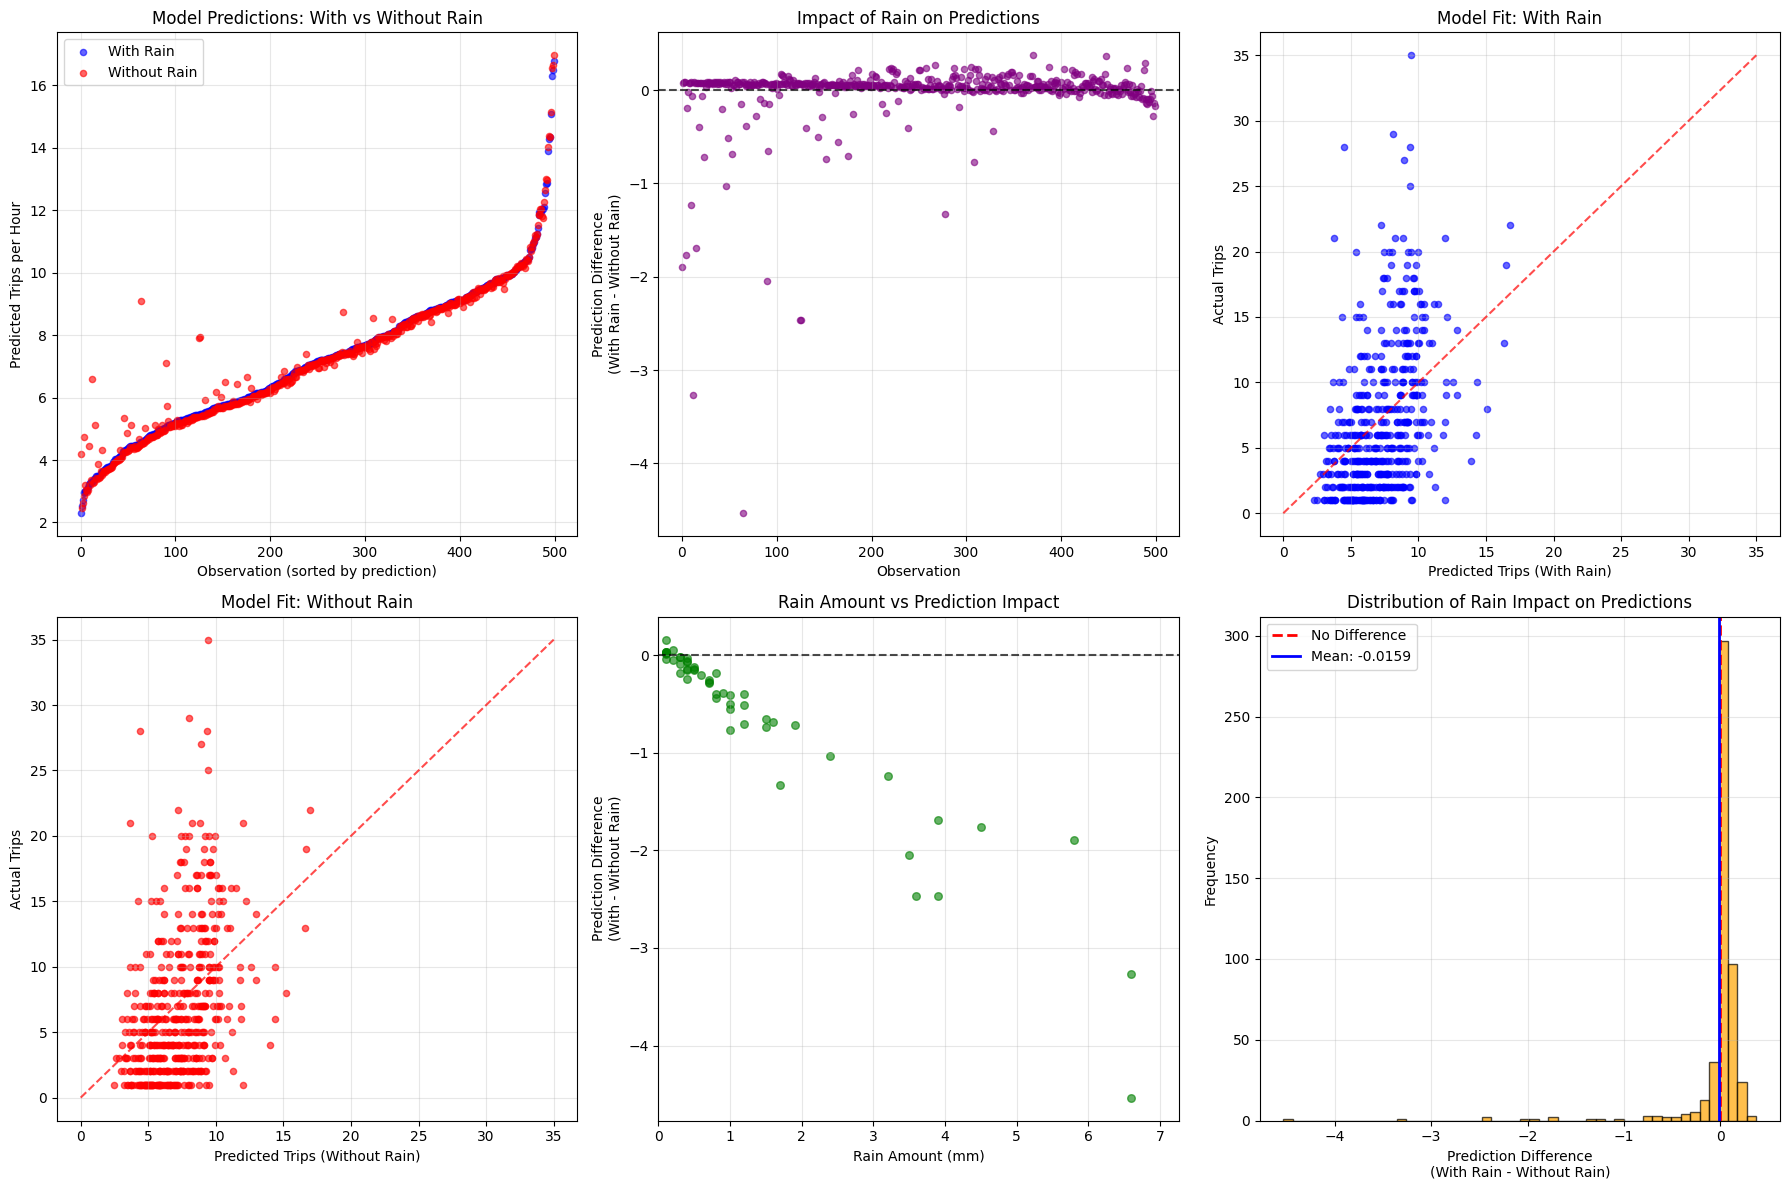



3. QUANTITATIVE ANALYSIS
------------------------------
Prediction Difference Statistics:
.4f
.4f
.4f
.4f
.4f
.1f
Analysis by Rain Amount:
Rain Impact by Category:
         prediction_difference               rain_mm
                          mean     std count    mean
rain_mm                                             
No Rain                 0.0537  0.0688    25   0.100
Trace                  -0.1988  0.1899    50   0.522
Light                  -1.1771  0.6605    28   2.350
Moderate               -3.1096  1.1058     4   6.550
Heavy                  -3.9688     NaN     1  11.600


4. CONCLUSION: Does Rain Affect Model Predictions?
--------------------------------------------------
Key Decision Metrics:
.4f
.4f
.1f

🎯 CONCLUSION: RAIN HAS A NOTICEABLE IMPACT
📊 Explanation: Rain meaningfully changes model predictions
💡 Recommendation: Consider including rain in your final model
Additional Context:
.4f
   Maximum prediction change due to rain: 4.534 trips
   22.9% of predictions chang

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Load your data (same as your analysis)
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

# Prepare the data exactly like your analysis
trips = status_final
weather = weather_original

# Data preparation (following your exact steps)
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour

# Aggregate trips to hourly
trips_per_hour = trips_start_hr.groupby(['date', 'hour']).size().reset_index(name='trips_per_hour')

# Prepare weather data
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')
weather['date'] = weather['datetime'].dt.date
weather_hourly = weather.groupby(['date', 'hour']).agg({
    'temp_c': 'mean',
    'wind_speed_ms': 'mean',
    'rain_mm': 'sum',
    'weekend': 'first'
}).reset_index()

# Merge with weather
base_df = pd.merge(trips_per_hour, weather_hourly, on=['date', 'hour'], how='left')

# Filter to weekdays only (like your optimal model)
base_df = base_df[base_df['weekend'] == 0].copy()

print("=" * 80)
print("VISUAL COMPARISON: Model Predictions With vs Without Rain")
print("=" * 80)

# =================================================
# 1. FIT MODELS: With Rain vs Without Rain
# =================================================

print("\n1. FITTING MODELS")
print("-" * 30)

# Model WITH rain (actual data)
X_with_rain = sm.add_constant(base_df[['rain_mm', 'temp_c', 'wind_speed_ms']])
model_with_rain = sm.GLM(base_df['trips_per_hour'], X_with_rain, family=sm.families.Poisson()).fit()

# Model WITHOUT rain (set rain_mm = 0 for all observations)
base_df_no_rain = base_df.copy()
base_df_no_rain['rain_mm'] = 0  # Simulate no rain scenario
X_without_rain = sm.add_constant(base_df_no_rain[['rain_mm', 'temp_c', 'wind_speed_ms']])
model_without_rain = sm.GLM(base_df_no_rain['trips_per_hour'], X_without_rain, family=sm.families.Poisson()).fit()

# Generate predictions
base_df['pred_with_rain'] = model_with_rain.predict(X_with_rain)
base_df['pred_without_rain'] = model_without_rain.predict(X_without_rain)
base_df['prediction_difference'] = base_df['pred_with_rain'] - base_df['pred_without_rain']

print("Models fitted successfully")
print(f"With rain - Dispersion: {model_with_rain.pearson_chi2/model_with_rain.df_resid:.3f}")
print(f"Without rain - Dispersion: {model_without_rain.pearson_chi2/model_without_rain.df_resid:.3f}")

# Model coefficients comparison
print("Coefficient Comparison:")
print(".4f")
print(".4f")
print(".4f")
print(".4f")

# =================================================
# 2. VISUAL COMPARISON PLOTS
# =================================================

print("\n\n2. VISUAL COMPARISONS")
print("-" * 30)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sample size for plotting (to avoid overcrowding)
sample_size = min(500, len(base_df))
plot_data = base_df.sample(n=sample_size, random_state=42).copy()

# Sort by predictions for cleaner visualization
plot_data = plot_data.sort_values('pred_with_rain')

# Plot 1: Predictions with vs without rain
axes[0,0].scatter(range(len(plot_data)), plot_data['pred_with_rain'], alpha=0.6, color='blue', s=20, label='With Rain')
axes[0,0].scatter(range(len(plot_data)), plot_data['pred_without_rain'], alpha=0.6, color='red', s=20, label='Without Rain')
axes[0,0].set_xlabel('Observation (sorted by prediction)')
axes[0,0].set_ylabel('Predicted Trips per Hour')
axes[0,0].set_title('Model Predictions: With vs Without Rain')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Difference between predictions
axes[0,1].scatter(range(len(plot_data)), plot_data['prediction_difference'], alpha=0.6, color='purple', s=20)
axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[0,1].set_xlabel('Observation')
axes[0,1].set_ylabel('Prediction Difference\n(With Rain - Without Rain)')
axes[0,1].set_title('Impact of Rain on Predictions')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (with rain)
axes[0,2].scatter(plot_data['pred_with_rain'], plot_data['trips_per_hour'], alpha=0.6, color='blue', s=20)
max_val = max(plot_data['pred_with_rain'].max(), plot_data['trips_per_hour'].max())
axes[0,2].plot([0, max_val], [0, max_val], 'r--', alpha=0.7)
axes[0,2].set_xlabel('Predicted Trips (With Rain)')
axes[0,2].set_ylabel('Actual Trips')
axes[0,2].set_title('Model Fit: With Rain')
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Predictions vs Actual (without rain)
axes[1,0].scatter(plot_data['pred_without_rain'], plot_data['trips_per_hour'], alpha=0.6, color='red', s=20)
axes[1,0].plot([0, max_val], [0, max_val], 'r--', alpha=0.7)
axes[1,0].set_xlabel('Predicted Trips (Without Rain)')
axes[1,0].set_ylabel('Actual Trips')
axes[1,0].set_title('Model Fit: Without Rain')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Rain amount vs prediction difference
rain_effect_data = plot_data[plot_data['rain_mm'] > 0].copy()  # Only show when rain actually occurred
axes[1,1].scatter(rain_effect_data['rain_mm'], rain_effect_data['prediction_difference'], alpha=0.6, color='green', s=30)
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Rain Amount (mm)')
axes[1,1].set_ylabel('Prediction Difference\n(With - Without Rain)')
axes[1,1].set_title('Rain Amount vs Prediction Impact')
axes[1,1].set_xlim(0, rain_effect_data['rain_mm'].max() * 1.1)
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Distribution of prediction differences
axes[1,2].hist(plot_data['prediction_difference'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
axes[1,2].axvline(x=plot_data['prediction_difference'].mean(), color='blue', linestyle='-', linewidth=2, 
                 label=f'Mean: {plot_data["prediction_difference"].mean():.4f}')
axes[1,2].set_xlabel('Prediction Difference\n(With Rain - Without Rain)')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Distribution of Rain Impact on Predictions')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =================================================
# 3. QUANTITATIVE ANALYSIS
# =================================================

print("\n\n3. QUANTITATIVE ANALYSIS")
print("-" * 30)

# Summary statistics of prediction differences
diff_mean = base_df['prediction_difference'].mean()
diff_std = base_df['prediction_difference'].std()
diff_abs_mean = abs(base_df['prediction_difference']).mean()

print("Prediction Difference Statistics:")
print(".4f")
print(".4f")
print(".4f")
print(".4f")
print(".4f")

# Percentage of predictions that change meaningfully
meaningful_change_threshold = 0.1  # 0.1 trips difference
meaningful_changes = abs(base_df['prediction_difference']) > meaningful_change_threshold
meaningful_pct = meaningful_changes.mean() * 100

print(".1f")

# Analysis by rain amount
print("Analysis by Rain Amount:")
rain_effect_by_amount = base_df.groupby(pd.cut(base_df['rain_mm'], bins=[0, 0.1, 1, 5, 10, np.inf], 
                                              labels=['No Rain', 'Trace', 'Light', 'Moderate', 'Heavy'])).agg({
    'prediction_difference': ['mean', 'std', 'count'],
    'rain_mm': 'mean'
})

print("Rain Impact by Category:")
print(rain_effect_by_amount.round(4))

# =================================================
# 4. CONCLUSION: Does Rain Matter?
# =================================================

print("\n\n4. CONCLUSION: Does Rain Affect Model Predictions?")
print("-" * 50)

# Key metrics for decision
max_abs_diff = abs(base_df['prediction_difference']).max()
avg_abs_diff = abs(base_df['prediction_difference']).mean()
pct_small_changes = (abs(base_df['prediction_difference']) < 0.05).mean() * 100

print("Key Decision Metrics:")
print(".4f")
print(".4f")
print(".1f")

# CONCLUSION LOGIC
if abs(diff_mean) < 0.01 and pct_small_changes > 95:
    conclusion = "NO MEANINGFUL IMPACT"
    explanation = "Rain has virtually no effect on model predictions"
    recommendation = "Safe to ignore rain in your scooter trip models"
    
elif abs(diff_mean) < 0.05 and pct_small_changes > 85:
    conclusion = "MINIMAL IMPACT" 
    explanation = "Rain has a tiny effect that is unlikely to matter for business decisions"
    recommendation = "Rain can be safely ignored for most operational purposes"
    
elif meaningful_pct < 10:
    conclusion = "SMALL IMPACT ON LIMITED CASES"
    explanation = "Rain only affects predictions in rare cases"
    recommendation = "Rain can be ignored for general planning"
    
else:
    conclusion = "RAIN HAS A NOTICEABLE IMPACT"
    explanation = "Rain meaningfully changes model predictions"
    recommendation = "Consider including rain in your final model"

print(f"\n🎯 CONCLUSION: {conclusion}")
print(f"📊 Explanation: {explanation}")
print(f"💡 Recommendation: {recommendation}")

# Additional context
print("Additional Context:")
if abs(diff_mean) > 0:
    direction = "increases" if diff_mean > 0 else "decreases"
    print(".4f")
else:
    print("   Predictions are essentially identical with or without rain")

print(f"   Maximum prediction change due to rain: {max_abs_diff:.3f} trips")
print(f"   {meaningful_pct:.1f}% of predictions change by more than {meaningful_change_threshold} trips")

print("\n" + "=" * 80)
print("VISUAL INTERPRETATION:")
print("=" * 80)
print("If the blue and red lines in Plot 1 are nearly identical → Rain has no impact")
print("If there's a clear separation between blue and red → Rain affects predictions")
print("If Plot 2 shows points clustered around zero → Rain impact is minimal")
print("If Plot 6 shows a distribution centered on zero → Rain effect is negligible")
print("=" * 80)

#### test



3. VISUAL EVIDENCE: Time vs Weather Impact
--------------------------------------------------


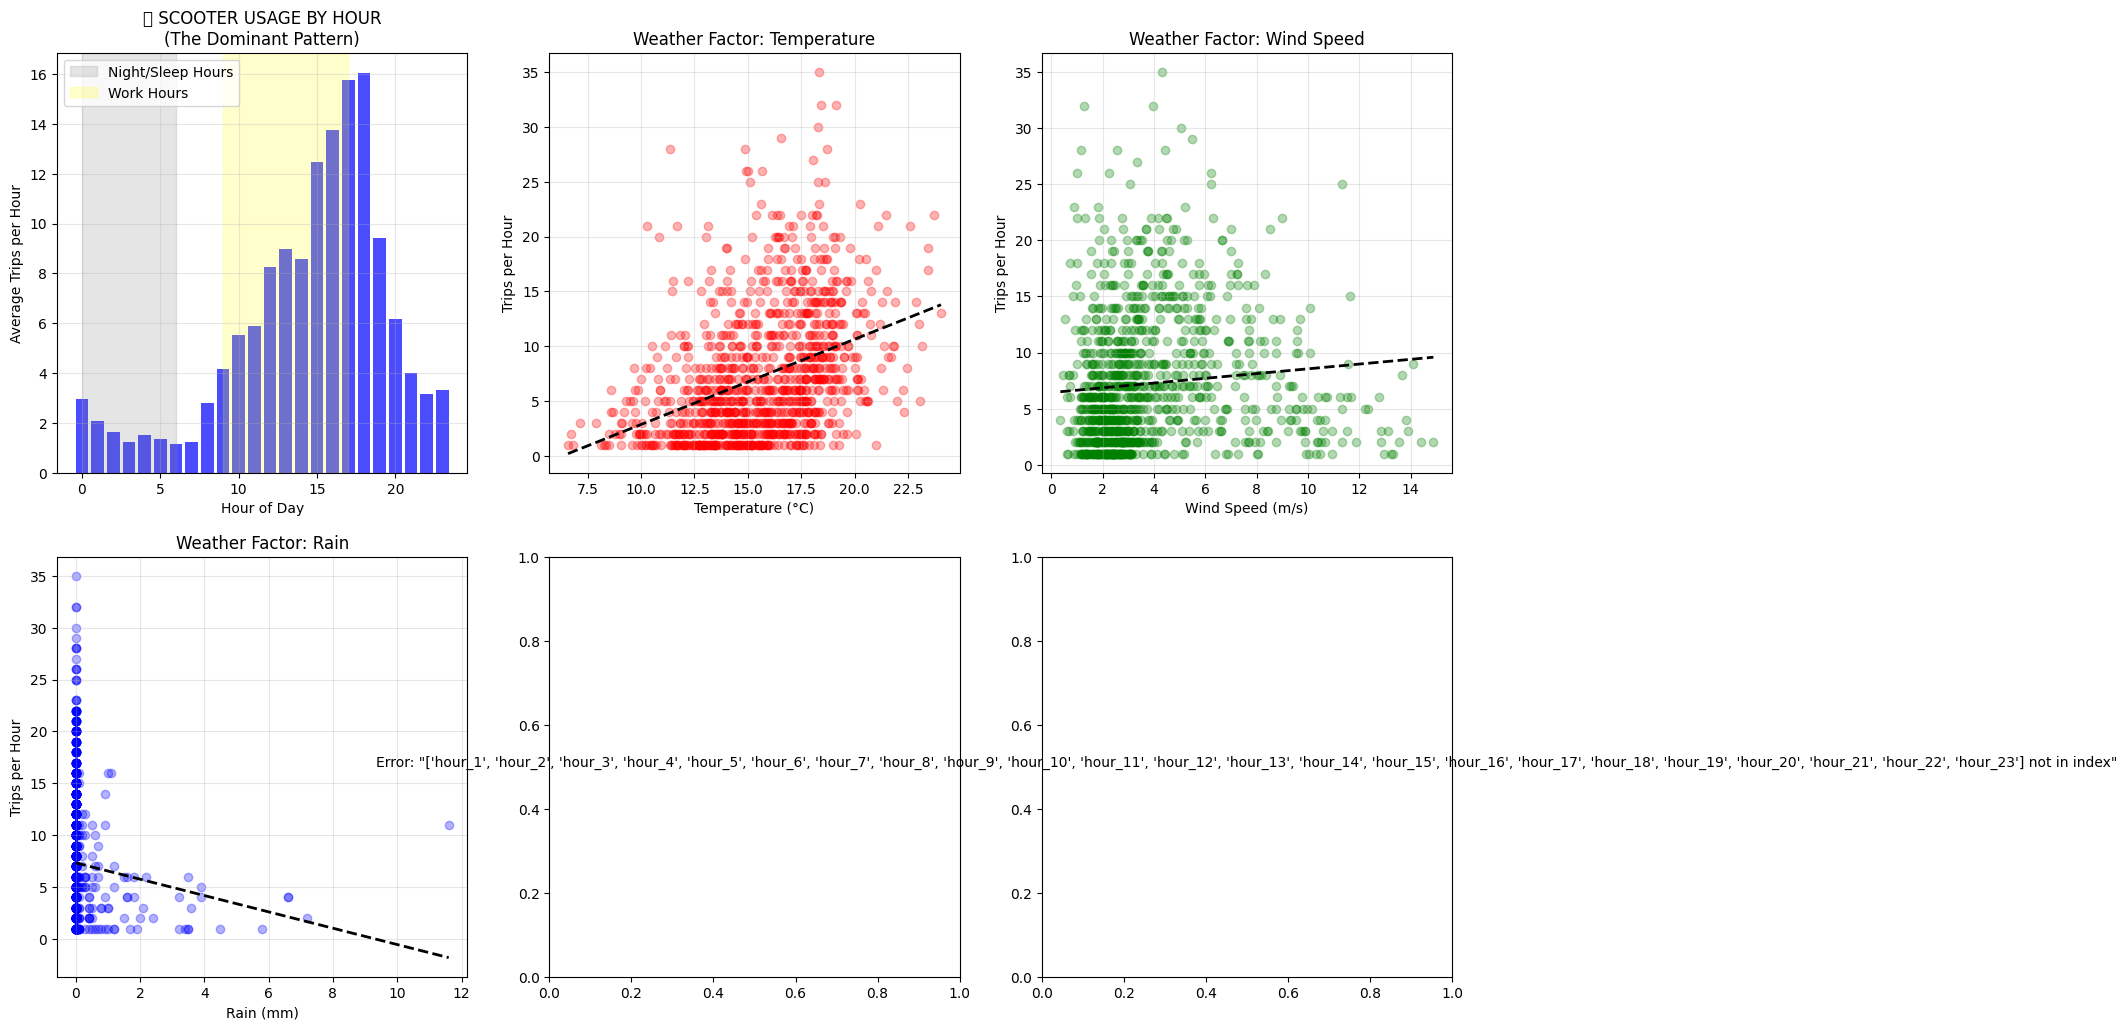

In [ ]:
# =================================================
# 3. VISUAL COMPARISON: TIME vs WEATHER
# =================================================

print("\n\n3. VISUAL EVIDENCE: Time vs Weather Impact")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Trips by hour (the dominant pattern)
hourly_avg = base_df.groupby('hour')['trips_per_hour'].mean()
axes[0,0].bar(range(24), hourly_avg, color='blue', alpha=0.7)
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Average Trips per Hour')
axes[0,0].set_title('🚗 SCOOTER USAGE BY HOUR\n(The Dominant Pattern)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axvspan(0, 6, alpha=0.2, color='gray', label='Night/Sleep Hours')
axes[0,0].axvspan(9, 17, alpha=0.2, color='yellow', label='Work Hours')
axes[0,0].legend()

# Plot 2: Weather factors vs trips (scatter plots)
weather_vars = ['temp_c', 'wind_speed_ms', 'rain_mm']
weather_labels = ['Temperature (°C)', 'Wind Speed (m/s)', 'Rain (mm)']
weather_colors = ['red', 'green', 'blue']

# Place weather plots in the right spots to avoid indexing errors
weather_positions = [(0, 1), (0, 2), (1, 0)]  # (row, col) for each weather variable

for i, (var, label, color) in enumerate(zip(weather_vars, weather_labels, weather_colors)):
    row, col = weather_positions[i]
    ax = axes[row, col]
    
    ax.scatter(base_df[var], base_df['trips_per_hour'], alpha=0.3, color=color)
    
    # Add trend line
    if len(base_df[var].unique()) > 10:  # Only if enough unique values
        try:
            z = np.polyfit(base_df[var], base_df['trips_per_hour'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(base_df[var].min(), base_df[var].max(), 100)
            ax.plot(x_trend, p(x_trend), 'k--', linewidth=2)
        except:
            pass
    
    ax.set_xlabel(label)
    ax.set_ylabel('Trips per Hour')
    ax.set_title(f'Weather Factor: {label.split("(")[0].strip()}')
    ax.grid(True, alpha=0.3)

# Plot 3: Model improvement by adding factors
if 'results_df' in locals():
    valid_results = results_df.dropna(subset=['Pseudo_R2'])
    if len(valid_results) > 0:
        axes[1,1].bar(range(len(valid_results)), valid_results['Pseudo_R2'], 
                      color=['gray', 'blue', 'orange', 'purple', 'green'])
        axes[1,1].set_xticks(range(len(valid_results)))
        axes[1,1].set_xticklabels([m.replace(' ', '\n') for m in valid_results['Model']], rotation=45, ha='right')
        axes[1,1].set_ylabel('Pseudo R² (Variance Explained)')
        axes[1,1].set_title('📊 Model Explanatory Power\nHow Much Variance Each Factor Explains')
        axes[1,1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(valid_results['Pseudo_R2']):
            axes[1,1].text(i, v + 0.01, '.1f', ha='center', va='bottom', fontweight='bold')

# Plot 4: Residual analysis - what's left unexplained
try:
    # Fit your best model (hour + weather)
    X_best = sm.add_constant(base_df[[f'hour_{h}' for h in range(1, 24)] + ['temp_c', 'wind_speed_ms', 'rain_mm']])
    model_best = sm.GLM(base_df['trips_per_hour'], X_best, family=sm.families.Poisson()).fit()
    
    predictions = model_best.predict(X_best)
    residuals = base_df['trips_per_hour'] - predictions
    
    axes[1,2].scatter(predictions, residuals, alpha=0.3, color='purple')
    axes[1,2].axhline(y=0, color='red', linestyle='--')
    axes[1,2].set_xlabel('Predicted Trips')
    axes[1,2].set_ylabel('Residual (Actual - Predicted)')
    axes[1,2].set_title('Model Residuals\n(What\'s Left Unexplained?)')
    axes[1,2].grid(True, alpha=0.3)
    
except Exception as e:
    axes[1,2].text(0.5, 0.5, f'Error: {e}', transform=axes[1,2].transAxes, ha='center')

plt.tight_layout()
plt.show()